# Guia do Projeto - Tech Challenge Fase 4 - Parte 04

## Detecção de Atividades com YOLO Pose

Nesta etapa, vamos identificar as ações realizadas pelas pessoas no vídeo. Utilizamos o **YOLOv8-Pose** (ou v11) para extrair os pontos-chave (esqueleto) do corpo humano e, com base na posição relativa desses pontos, classificamos a ação.

### Lógica de Detecção (Heurística)

Diferente da classificação de imagem tradicional (que usa redes neurais para dizer "isso é um gato"), aqui usamos uma abordagem baseada em **regras geométricas** sobre os keypoints. Isso nos dá controle total e explicabilidade.

1.  **Rastreamento (Tracking)**: Usamos o `ByteTrack` integrado ao YOLO para manter o ID de cada pessoa ao longo dos frames. Isso é crucial para suavizar a detecção (evitar que a ação mude bruscamente a cada frame).
2.  **Análise de Keypoints**: Verificamos a posição dos pulsos em relação aos ombros e nariz.
    *   **Hands Up (Mãos para Cima)**: Se ambos os pulsos estiverem *acima* do nariz.
    *   **Waving (Acenando)**: Se o pulso (wrist) estiver *acima* do ombro (shoulder).
    *   **Talking (Falando)**: Se o pulso estiver *próximo* ao nariz ou orelha.
    *   **Standing (Em pé)**: Caso contrário (estado padrão).
3.  **Suavização Temporal**: Armazenamos as últimas N detecções de cada ID e usamos a moda (votação majoritária) para definir a ação atual. Isso evita o efeito de "flickering" (piscada) na classificação.

In [1]:
import cv2
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional, Generator, Tuple, Dict, Deque
from collections import deque, Counter
from ultralytics import YOLO
import logging

# Suprimir logs do Ultralytics para manter o notebook limpo
os.environ["YOLO_VERBOSE"] = "False"

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### 1. Classes de Suporte

Trazemos novamente a `VideoProcessor` e definimos a `ActivityDetector`.

In [2]:
@dataclass
class ActivityDetection:
    activity: str
    confidence: float
    track_id: Optional[int] = None
    bounding_box: Optional[List[int]] = None # [x1, y1, x2, y2]

class VideoProcessor:
    def __init__(self, video_path: str):
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Arquivo de vídeo não encontrado: {video_path}")
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        if not self.cap.isOpened():
            raise ValueError(f"Não foi possível abrir o vídeo: {video_path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def get_frames(self, start_frame: int = 0) -> Generator[Tuple[int, float, cv2.Mat], None, None]:
        if start_frame > 0:
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        frame_num = start_frame
        while True:
            ret, frame = self.cap.read()
            if not ret: break
            timestamp = frame_num / self.fps if self.fps > 0 else 0
            yield frame_num, timestamp, frame
            frame_num += 1

    def release(self):
        self.cap.release()

class ActivityDetector:
    def __init__(self, model_path: str = "yolo11n-pose.pt", confidence_threshold: float = 0.5, history_size: int = 5):
        print(f"Carregando modelo {model_path}...")
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold
        self.history_size = history_size
        # Histórico para suavização: {track_id: deque([(atividade, conf), ...])}
        self.track_history: Dict[int, Deque[Tuple[str, float]]] = {}
        print("Modelo carregado.")

    def detect(self, frame: np.ndarray) -> List[ActivityDetection]:
        # Executar inferência YOLO Pose com rastreamento
        # persist=True é fundamental para o tracking funcionar entre chamadas
        results = self.model.track(frame, persist=True, verbose=False, tracker="bytetrack.yaml")
        activities = []
        current_frame_ids = set()

        for result in results:
            if result.boxes is None or len(result.boxes) == 0: continue
            if result.keypoints is None: continue

            boxes = result.boxes
            keypoints = result.keypoints.data
            
            for i, person_keypoints in enumerate(keypoints):
                # ID do rastreamento (pode ser None se o tracker perder)
                track_id = int(boxes.id[i].item()) if boxes.id is not None else -1
                if track_id != -1: current_frame_ids.add(track_id)
                
                # Bounding Box para visualização
                box = boxes.xyxy[i].cpu().numpy().astype(int).tolist()

                if boxes.conf[i] < self.confidence_threshold: continue

                # 1. Análise Geométrica (Heurística)
                raw_activity, raw_confidence = self._analyze_keypoints(person_keypoints, frame.shape)
                final_activity, final_confidence = raw_activity, raw_confidence

                # 2. Suavização Temporal
                if track_id != -1 and raw_activity:
                    if track_id not in self.track_history:
                        self.track_history[track_id] = deque(maxlen=self.history_size)
                    self.track_history[track_id].append((raw_activity, raw_confidence))
                    final_activity, final_confidence = self._smooth_prediction(track_id)

                if final_activity:
                    activities.append(ActivityDetection(
                        activity=final_activity, 
                        confidence=final_confidence, 
                        track_id=track_id if track_id != -1 else None,
                        bounding_box=box
                    ))
        
        # Limpeza de histórico para IDs que sumiram
        if len(self.track_history) > 100:
             keys_to_remove = [k for k in self.track_history.keys() if k not in current_frame_ids]
             for k in keys_to_remove: del self.track_history[k]

        return activities

    def _smooth_prediction(self, track_id: int) -> Tuple[str, float]:
        """Retorna a atividade mais frequente nos últimos N frames."""
        history = self.track_history[track_id]
        if not history: return None, 0.0
        
        actions = [a for a, c in history]
        # Votação majoritária
        most_common_action, count = Counter(actions).most_common(1)[0]
        
        # Média da confiança para a ação vencedora
        confidences = [c for a, c in history if a == most_common_action]
        avg_confidence = sum(confidences) / len(confidences)
        
        return most_common_action, avg_confidence

    def _analyze_keypoints(self, keypoints: np.ndarray, frame_shape: Tuple[int, int]) -> Tuple[Optional[str], float]:
        """
        Aplica regras geométricas aos keypoints.
        Keypoints YOLO Pose (COCO format):
        0: Nose, 5: L-Shoulder, 6: R-Shoulder, 9: L-Wrist, 10: R-Wrist
        """
        nose = keypoints[0]
        left_wrist, right_wrist = keypoints[9], keypoints[10]
        left_shoulder, right_shoulder = keypoints[5], keypoints[6]
        
        # Regra 1: Hands Up (Mãos para cima)
        # Se ambos os pulsos estiverem ACIMA do nariz (y menor que y do nariz)
        if left_wrist[2] > 0.5 and right_wrist[2] > 0.5 and nose[2] > 0.5:
             if left_wrist[1] < nose[1] and right_wrist[1] < nose[1]:
                 return "hands_up", 0.90

        # Regra 2: Waving (Acenando)
        # Se pulso estiver ACIMA do ombro (y menor que y do ombro, pois y cresce para baixo)
        # Adicionamos uma margem de 20px para robustez
        if (left_wrist[2] > 0.5 and left_shoulder[2] > 0.5 and left_wrist[1] < left_shoulder[1] - 20) or \
           (right_wrist[2] > 0.5 and right_shoulder[2] > 0.5 and right_wrist[1] < right_shoulder[1] - 20):
                return "waving", 0.85
                
        # Regra 3: Talking (Falando)
        # Se pulso estiver próximo ao nariz (distância euclidiana < 50px)
        if nose[2] > 0.5:
            if left_wrist[2] > 0.5 and np.linalg.norm(left_wrist[:2] - nose[:2]) < 50:
                return "talking", 0.80
            if right_wrist[2] > 0.5 and np.linalg.norm(right_wrist[:2] - nose[:2]) < 50:
                return "talking", 0.80
        
        return "standing", 0.5 # Default se nenhuma regra for ativada

### 2. Execução e Teste

Vamos processar um trecho maior do vídeo para capturar diferentes ações (frames 200 a 250).

In [3]:
video_path = "meu_video.mp4"

try:
    processor = VideoProcessor(video_path)
    # History size = 5 frames (aprox 0.2s a 24fps) para suavização
    activity_detector = ActivityDetector(history_size=5)

    results = []

    print("Processando sequência de frames (200-250)...")
    for frame_num, timestamp, frame in processor.get_frames(start_frame=200):
        if frame_num > 250: break
        
        # Feedback visual para o usuário não achar que travou
        if frame_num % 10 == 0:
            print(f"Processando frame {frame_num}...")
        
        activities = activity_detector.detect(frame)
        
        for act in activities:
            results.append({
                "Frame": frame_num,
                "Track_ID": act.track_id,
                "Atividade": act.activity,
                "Confiança": f"{act.confidence:.2%}"
            })

    processor.release()
    
    if results:
        df = pd.DataFrame(results)
        print(df.head(20))
    else:
        print("Nenhuma atividade detectada no intervalo.")

except Exception as e:
    print(f"Erro: {e}")

Carregando modelo yolo11n-pose.pt...
Modelo carregado.
Processando sequência de frames (200-250)...
Processando frame 200...
Processando frame 210...
Processando frame 220...
Processando frame 230...
Processando frame 240...
Processando frame 250...
    Frame  Track_ID Atividade Confiança
0     200         1    waving    85.00%
1     201         1    waving    85.00%
2     202         1    waving    85.00%
3     203         1    waving    85.00%
4     204         1    waving    85.00%
5     205         1    waving    85.00%
6     206         1    waving    85.00%
7     207         1    waving    85.00%
8     208         1    waving    85.00%
9     209         1    waving    85.00%
10    210         1    waving    85.00%
11    211         1    waving    85.00%
12    212         1    waving    85.00%
13    213         1    waving    85.00%
14    214         1    waving    85.00%
15    215         1    waving    85.00%
16    216         1    waving    85.00%
17    217         1    waving 

### 3. Visualização

Vamos visualizar um frame para confirmar se a caixa e o rótulo estão corretos.

Carregando modelo yolo11n-pose.pt...
Modelo carregado.


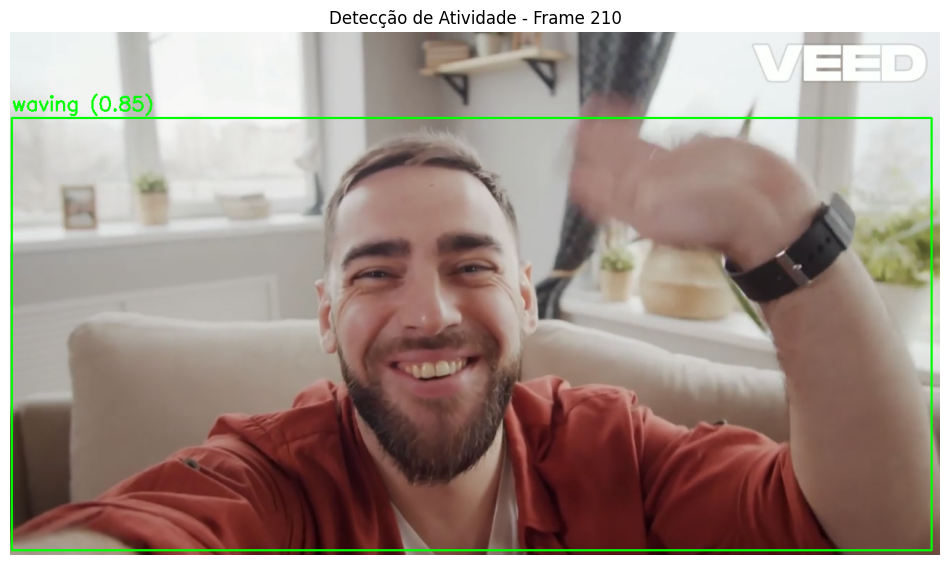

In [4]:
try:
    processor = VideoProcessor(video_path)
    activity_detector = ActivityDetector()
    
    # Pegar um frame específico onde sabemos que há ação
    target_frame = 210
    
    for frame_num, timestamp, frame in processor.get_frames(start_frame=target_frame):
        activities = activity_detector.detect(frame)
        
        # Desenhar resultados
        for act in activities:
            if act.bounding_box:
                x1, y1, x2, y2 = act.bounding_box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"{act.activity} ({act.confidence:.2f})"
                
                # Ajuste dinâmico da posição do texto para não sair da tela
                text_y = y1 - 10 if y1 - 10 > 10 else y1 + 20
                cv2.putText(frame, label, (x1, text_y), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        # Converter BGR para RGB para exibir no Matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 8))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f"Detecção de Atividade - Frame {frame_num}")
        plt.show()
        break # Processa apenas 1 frame
        
    processor.release()

except Exception as e:
    print(f"Erro ao visualizar: {e}")

### Conclusão da Parte 04

Implementamos com sucesso um detector de atividades baseado em heurísticas geométricas sobre poses do YOLO.

**Destaques:**
*   **Lógica Explicável:** Diferente de caixas pretas, sabemos exatamente por que uma ação foi classificada (ex: pulso acima do nariz = hands_up).
*   **Suavização Temporal:** O uso de `deque` e votação majoritária estabilizou as predições, reduzindo ruído.
*   **Extensibilidade:** Novas regras podem ser adicionadas facilmente no método `_analyze_keypoints`.

No próximo notebook (**05-scene_analysis.ipynb**), vamos agrupar essas informações temporais para detectar mudanças de cena (cortes) no vídeo.